# Introduction to Stepwise Regression

## Data Science 410

In this notebook we will start our exploration of the mathematical basis of linear statistical models. The emphasis is on the ubiquitous problem of **model over-fitting** or **model over-parameterization**. 

Over-fitting (or over-parameterization) of machine learning models arises in any case where the number of model parameters exceeds the effective dimensions of the feature set. This is most often the result of linear dependency between the features. However, using too complex a model can lead to similar problems. In the extreme case, imagine a model with as many free parameters as training cases. This model might fit the training data perfectly, but will show unstable and unexpected results when used for other data. In machine learning terminology, we say that such an unstable model does not **generalize**. 

Many methods have been developed and continue to be developed to deal with over-parameterized or **ill-posed** machine learning models. In particular, we will explore three methods for stabilizing over-parameterized models: 

- Stepwise regression, wherein features are eliminated from an over-parameterized model in a stepwise fashion. Stepwise regression is the focus of this notebook. 
- Using a mathematical **regularization** technique, known as singular value decomposition, to determine the number of meaningful components for a model. We will explore use of singular value decomposition in another notebook. 
- Using **regularization** methods known as ridge, lasso, and elastic-net regression to stabilize over-parameterized models. We will explore ridge and lasso regression in another notebook.

![](img/Extrapolation.png)
<center> Warning!! Extrapolation can be dangerious!! </center>


## Introduction to Stepwise Regression

**Stepwise regression** uses model performance metrics to prune the number of features in a model. There are two possible approaches: 
1. The steps can be **forward**, wherein features are added one at a time in order of importance, until the metric used no longer improves. 
2. The steps can be **backward**, wherein a model using all features is pruned one feature at a time in reverse order of importance until the metric used becomes significantly worse. 

It is also possible to step in both directions. In practice, either backward steps or using both directions are used, since forward steps have a tendency to get stuck at poor solutions. 

### The Akaike Information Criterion

A significant issue with stepwise regression is to choose a performance metric. Many commonly used error metrics like RMSE will naturally get better as we add more features or model parameters. Consequently the **Akaike information criterion** (AIC) is often used. 

<img src="img/Akaike_1996.jpg" alt="Drawing" style="width:275x; height:350px"/>

<center>Hirotugu Akaike receiving Japan Statistical Society Prize 1996</center>   

The idea of the AIC is to trade-off two completing criteria:
1. Maximize the likelihood of the model. 
2. Minimize the complexity of the model to prevent over-parameterization. 

We can write the AIC as:

$$AIC = 2 k - 2 ln(\hat{L})\\
where\\
\hat{L} = the\ likelihood\ given\ the\ fitted\ model\ parameters\ \hat\theta = p(x| \hat\theta)\\
x = observed\ data\\
k = number\ of\ model\ parameters$$

In words, the AIC is the model log-likelihood adjusted for the number of model parameters. The objective is to **minimize the AIC**. 

The quantity $- 2 ln(p(x| \hat\theta))$ is sometimes referred to as the **deviance** of the model. Deviance is a measure of the relative likelihood of the model. Deviance is a generalization of the variance. Strictly, deviance measures the difference in distribution between a saturated model (number of parameters = number of observations), and the model being considered. The saturated model will have a perfect fit to the training data, but is highly over-parameterized.

### Pitfalls of Stepwise Regression

Stepwise regression is a form of multiple hypothesis testing. Therefore, it is subject to the problems inherent in this method:
1. The most important features may be rejected from the model. 
2. Unimportant features may be retained in the model. 

For these reasons, stepwise regression should be used with caution. It is generally the case that stepwise regression will not find optimal models if there are more than a few features to consider. 

## Example of Stepwise Regression

In this section we will work through an example of stepwise regression. We will start with an over-parameterized model. Both **forward stepwise regression** and **backward stepwise regression** will be applied to finding a better model. 

### Preparing the data

As a first step we will create a data set to use as a polynomial regression model example. 

Execute this code in the cells below to created the simulateddata. 

In [1]:
import pandas as pd
import numpy as np
import numpy.random as nr
import statsmodels.formula.api as sm
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Paramters of generated data
n_points = 100
x_start, x_end = 0, 10
y_sd = 2.0

# Generate data columns
nr.seed(474747)
x_data = np.linspace(x_start, x_end, n_points) # The x values
y_error = np.random.normal(loc=0, scale=y_sd, size=n_points) # The Normally distributed noise
y_data = x_data + 0.6 * np.square(x_data) + y_error + 1.0 # The y values including an intercept

# Put data in dataframe
sim_data = pd.DataFrame({'x':x_data, 'y':y_data})

sim_data.head()

,x,y
0,0.00000,3.163520
1,0.10101,1.888470
2,0.20202,-0.204768
3,0.30303,3.696364
4,0.40404,4.049431


Now execute the code in the cell below to compute some polynomial features and scale all features. 

In [3]:
# Create a scale function for a column in a pandas df
def scale(col):
    mean_col = np.mean(col)
    sd_col = np.std(col)
    std = (col - mean_col) / sd_col
    return std

## Create polynomial features
sim_data['x_square'] = np.square(sim_data.x)
sim_data['x_cube'] = np.multiply(sim_data.x, sim_data.x_square)

## Scale the features
for col in ['x','x_square','x_cube']:
    sim_data[col] = scale(sim_data[col])
    
sim_data.head(10)

,x,y,x_square,x_cube
0,-1.714816,3.163520,-1.111808,-0.878063
1,-1.680173,1.888470,-1.111470,-0.878059
2,-1.645531,-0.204768,-1.110454,-0.878034
3,-1.610888,3.696364,-1.108761,-0.877966
4,-1.576245,4.049431,-1.106391,-0.877834
5,-1.541602,1.693712,-1.103343,-0.877615
6,-1.506960,-0.714178,-1.099619,-0.877289
7,-1.472317,0.455908,-1.095217,-0.876834
8,-1.437674,-1.831612,-1.090138,-0.876228
9,-1.403031,1.745986,-1.084381,-0.875450


Next, run the code in the cell below to randomly select observations for a train and test sample.

In [4]:
sim_data_train = sim_data.sample(frac=0.5,random_state=234) #random state is a seed value
sim_data_test = sim_data.drop(sim_data_train.index)
print(sim_data_train.shape, '  ', sim_data_test.shape)

(50, 4)    (50, 4)


### Fitting the Polynomial Regression Model

The code in the cell below fits a OLS model to the training data. Execute this code and examine the summary of the model fit.

In [5]:
## Define the regresson model and fit it to the data
ols_model_1 = sm.ols(formula = 'y ~ x + x_square + x_cube', data=sim_data_train).fit()

## Print the model summary
ols_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1896.
Date:                Tue, 18 Feb 2020   Prob (F-statistic):           3.47e-48
Time:                        20:37:11   Log-Likelihood:                -102.75
No. Observations:                  50   AIC:                             213.5
Df Residuals:                      46   BIC:                             221.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.1758      0.280     93.355      0.000      25.611      26.740
x              3.9843      2.827      1.410      0.165      -1.705       9.674
x_square      14.9643      6.816      2.196      0.033       1.245      28.684
x_cube         1.9680      4.263      0.462      0.647      -6.613      10.549
==============================================================================
Omnibus:                        2.930   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.231   Jarque-Bera (JB):                2.233
Skew:                           0.513   Prob(JB):                        0.327
Kurtosis:                       3.143   Cond. No.                         52.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Examine the table of significance of the model coefficients. **The model is over-fit**, with two of the coefficients not significant. Also, note the value of $R^2$ and AIC. 

Despite the over-fitting, we should look at the residuals. Execute the code in the cell below to do so.  

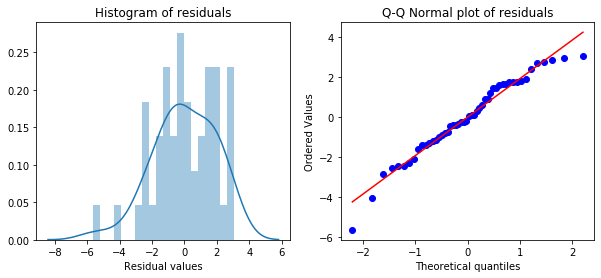

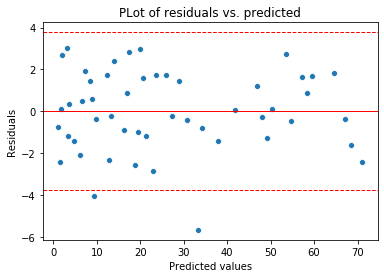

In [6]:
def plot_resid_dist(resids):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    ## Plot a histogram
    sns.distplot(resids, bins=20, ax=ax[0])
    ax[0].set_title('Histogram of residuals')
    ax[0].set_xlabel('Residual values')
    ## Plot the Q-Q Normal plot
    ss.probplot(resids, plot = ax[1])
    ax[1].set_title('Q-Q Normal plot of residuals')
    plt.show()


def residual_plot(df):
    RMSE = np.std(df.resids)
    sns.scatterplot(x='predicted', y='resids', data=df)
    plt.axhline(0.0, color='red', linewidth=1.0)
    plt.axhline(2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0)
    plt.axhline(-2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0)
    plt.title('PLot of residuals vs. predicted')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.show()
    
   
## Add predicted values and residuals to pandas dataframe
sim_data_train['predicted'] =  ols_model_1.predict(sim_data_train[['x','x_square','x_cube']])
sim_data_train['resids'] = np.subtract(sim_data_train.predicted, sim_data_train.y)

## Create the residal plots
plot_resid_dist(sim_data_train.resids)
residual_plot(sim_data_train) 

These residuals look well behaved; close to Normally distributed and homoscedastic. 

We can now see how well the model fits the test data. Execute the code in the cell below to compute the RMSE and plot the observations vs. the fitted curve.   

RMSE = 15.363


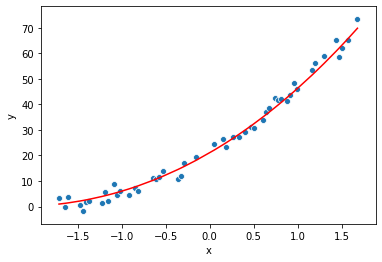

In [9]:
from math import sqrt 
def plot_ols(df, model, features):
    ## Compute the predicted values and residuals
    df['predicted'] =  ols_model_1.predict(df[features])
    df['resids'] = np.subtract(df.predicted, df.y)
    print('RMSE = %6.3f' % sqrt(np.sum(np.square(df.resids))))
    ## display the plot
    ax = sns.lineplot(x='x', y='predicted', data=df, color='red')
    sns.scatterplot(x='x', y='y', data=df, ax=ax)
    
plot_ols(sim_data_test, ols_model_1, ['x','x_square','x_cube'])

In this case, the fit of the test data to the model is reasonably good. This will often not be the case with over-fit models. 

### Apply forward stepwise regression

The code we will use for forward stepwise regression assumes that all columns of the data frame, except the label column, are potential features. Therefore, you must execute the code in the cell below first.

In [10]:
## Drop the columns we don't want in the training data
sim_data_train.drop(['predicted', 'resids'], axis=1, inplace=True)

Now, execute the code in the cell below to perform forward stepwise regression and examine the results.

In [11]:
def forward_selected(data, response, verbose=True):
    """Linear model designed by forward selection. Based on AIC

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
    """
    # Start with no factors (intercept only)
    formula = "{} ~ 1".format(response)
    best_aic = sm.ols(formula, data).fit().aic
    
    # Go through remaining sets of variables one-by-one
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_aic = best_aic
    
    if(verbose):
                print('For formula ', formula, ' the AIC = ', current_aic)
    
    # Check if any variables remain and if we haven't improved by adding any yet
    while remaining and current_aic == best_aic:
        aic_candidates = []
        for candidate in remaining:
            # Try adding the candidate column
            formula = "{} ~ {} + 1".format(response, ' + '.join(selected + [candidate]))
            # Get AIC
            aic = sm.ols(formula, data).fit().aic
            # Append tuple of the form (aic, response)
            aic_candidates.append((aic, candidate))
            if(verbose):
                print('For formula ', formula, ' the AIC = ', aic)
        # Sort all the pairs by the first entry of tuple (default of sort() method)
        aic_candidates.sort()
        # Remember that the sort() method sorts by smallest to largest of first entry here.
        #   If you were to change the criteria to something that needs to be maximized, change sort/pop order!
        best_new_aic, best_candidate = aic_candidates.pop(0)
        # Now check if we have something better:
        if best_new_aic < current_aic:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_aic = best_new_aic
        # Now we repeat the process with all the remaining candidate columns

    # Here is the final formula!
    formula = "{} ~ {} + 1".format(response, ' + '.join(selected))
    # Get the model object
    model = sm.ols(formula, data).fit()
    
    if(verbose):
        print('\nThe selected model formula is ', model.model.formula)
        print('The final AIC =', model.aic)
        print('\nThe model summary is')
        print(model.summary())
    return model

#model = forward_selected(male_df, 'childHeight')
ols_model_fsw = forward_selected(sim_data_train, 'y')



For formula  y ~ 1  the AIC =  448.77006113576533
For formula  y ~ x_square + 1  the AIC =  216.03869042986184
For formula  y ~ x + 1  the AIC =  307.25016871973867
For formula  y ~ x_cube + 1  the AIC =  293.43495137242047

The selected model formula is  y ~ x_square + 1
The final AIC = 216.03869042986184

The model summary is
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     5201.
Date:                Tue, 18 Feb 2020   Prob (F-statistic):           1.34e-50
Time:                        20:41:50   Log-Likelihood:                -106.02
No. Observations:                  50   AIC:                             216.0
Df Residuals:                      48   BIC:                             219.9
Df Model:                           1 

The model has one feature plus the intercept. The AIC is bit higher. 



### Backward stepwise selection

Backward stepwise selection is a very similar algorithm.  Execute the code in the cell below and examine the results:

In [12]:
def backward_selected(data, response, verbose=True):
    """Linear model designed by backward selection. Based on AIC

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by backward selection
    """
    # Start with all factors and intercept
    possible_factors = set(data.columns)
    possible_factors.remove(response)
    formula = "{} ~ {} + 1".format(response, ' + '.join(possible_factors))
    
    # Fill out this formula!
    #--------------------------------
    # Fill in spot #1!!!!
    best_aic = sm.ols(formula, data).fit().aic
    #--------------------------------
    
    current_aic = best_aic
    
    if(verbose):
                print('For formula ', formula, ' the AIC = ', current_aic)
    
    # Set a non-empty set of columns that will be labeled as "to remove and try"
    to_try_remove = possible_factors
    
    # Check if any variables remain and if we haven't improved by adding any yet
    while to_try_remove and current_aic == best_aic:
        aic_candidates = []
        for candidate in to_try_remove:
            
            columns = possible_factors - set([candidate])
            # Try removing the candidate column
            formula = "{} ~ {} + 1".format(response, ' + '.join(columns))
            # Get AIC
            aic = sm.ols(formula, data).fit().aic
            
            if(verbose):
                print('For formula ', formula, ' the AIC = ', aic)
            
            # Append tuple of the form (aic, response)
            aic_candidates.append((aic, candidate))
            
        # Sort all the pairs by the first entry of tuple (default of sort() method)
        aic_candidates.sort()
        # Remember that the sort() method sorts by smallest to largest of first entry here.
        #   If you were to change the criteria to something that needs to be maximized, change sort/pop order!
        best_new_aic, best_candidate = aic_candidates.pop(0)
        
        # Now check if we have something better:
        if best_new_aic < current_aic:
            # Remove the best candidate's name from possible_factors
            
            #--------------------------------
            # Fill in spot #2!!!!
            possible_factors.remove(best_candidate)
            current_aic = best_new_aic
            #--------------------------------
            
        # Now we repeat the process with all the remaining candidate columns

    # Here is the final formula!
    formula = "{} ~ {} + 1".format(response, ' + '.join(possible_factors))
    # Get the model object
    model = sm.ols(formula, data).fit()
    
    if(verbose):
        print('\nThe selected model formula is ', model.model.formula)
        print('The final AIC =', model.aic)
        print('\nThe model summary is')
        print(model.summary())
    return model


ols_model_bsw = backward_selected(sim_data_train, 'y')

For formula  y ~ x_square + x + x_cube + 1  the AIC =  213.5047066855272
For formula  y ~ x_cube + x + 1  the AIC =  216.48769021973584
For formula  y ~ x_square + x_cube + 1  the AIC =  213.61907594772572
For formula  y ~ x_square + x + 1  the AIC =  211.73582984579141

The selected model formula is  y ~ x_square + x + 1
The final AIC = 211.73582984579141

The model summary is
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2892.
Date:                Tue, 18 Feb 2020   Prob (F-statistic):           6.32e-50
Time:                        20:43:37   Log-Likelihood:                -102.87
No. Observations:                  50   AIC:                             211.7
Df Residuals:                      47   BIC:                      

The model selected is identical to the model found with forward stepwise regression. In more complex problems this is often not the case.

**Your turn:**

The forward and backward stepwise regression has found the same optimal model. You will now do the following to evaluate the model:
1. Plot the distribution of the residuals using the training data.
2. Plot the residuals vs. the predicted values using the training data. 
3. Plot the predicted line along with observations in the sim_data_test data set.  
4. Compute and print the RMSE using the sim_data_test data set.



RMSE = 15.363


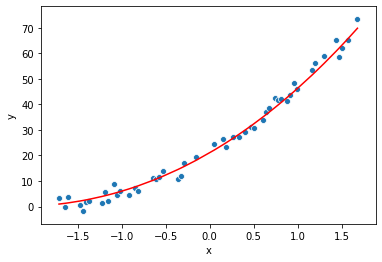

In [13]:
plot_ols(sim_data_test, ols_model_bsw, ['x','x_square','x_cube'])

How does this model compare to the model using all the features? 

#### Copyright 2017, 2018, 2020 Stephen F Elston. All rights reserved.